# Chapter 11 – Training Deep Neural Networks
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alirezatheh/handson-ml3-notes/blob/main/notebooks/11_training_deep_neural_networks.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/alirezatheh/handson-ml3-notes/blob/main/notebooks/11_training_deep_neural_networks.ipynb)

Problems of training deep neural networks:
- We may be faced with the problem of gradients growing ever smaller or larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.
- We might not have enough training data for such a large network, or it might be too costly to label.
- Training may be extremely slow.
- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

## Vanishing/Exploding Gradients Problem
- Gradients often get smaller and smaller as the backpropagation progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the *vanishing gradients* problem.
- In some cases, the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the *exploding gradients* problem, which happens most often in recurrent neural networks. 

More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

It wasn’t clear what caused the gradients to be so unstable until in a 2010 paper [“Understanding the Difficulty of Training Deep Feedforward Neural Networks”](https://homl.info/47), Xavier Glorot and Yoshua Bengio showed that with popular sigmoid activation function and the normal weight initialization (mean of 0 and a standard deviation of 1), the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the sigmoid function has a mean of 0.5, not 0.

### Glorot and He Initialization
Glorot and Bengio point out that we need the signal to flow properly in both directions. They argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction. It is actually not possible to guarantee both unless the layer has an equal number of inputs and outputs (*fan_in* and *fan_out*), but they proposed a good compromise that work well in practice: the connection weights of each layer must be initialized randomly as described in the following equation. This initialization strategy is called *Xavier initialization* or *Glorot initialization*.

**Equation 11-1** Glorot initialization (when using the sigmoid activation function)
$$
\begin{split}
&\text{Normal distribution with mean 0 and variance}\;
\sigma^2=\frac{1}{fan_\text{avg}}
\\&\text{Or a uniform distribution between $−r$ and $+r$, with}\;
r=\sqrt{\frac{3}{fan_\text{avg}}}
\end{split}
$$
- $fan_\text{avg}=(fan_\text{in}+fan_\text{out})/2$

If we replace $fan_\text{avg}$ with $fan_\text{in}$, we get an initialization strategy that Yann LeCun proposed in the 1990s. He called it *LeCun initialization*. In an 2015 paper, [“Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification”](https://homl.info/48) Kaiming He et al. provided a similar strategy.

| Initialization | Activation functions                     |  $\sigma^2$ (Normal) |
|----------------|------------------------------------------|----------------------|
| Glorot         | None, tanh, sigmoid, softmax             | $1/fan_\text{avg}$   |
| He             | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | $2/fan_\text{in}$    |
| LeCun          | SELU                                     | $1/fan_\text{in}$    |

By default, Keras uses Glorot initialization with a uniform distribution.

In [1]:
import keras
import tensorflow as tf

dense = keras.layers.Dense(
    50, activation='relu', kernel_initializer='he_normal'
)

He initialization with a uniform distribution and based on $fan_\text{avg}$ 
(rather than $fan_\text{in}$):

In [2]:
he_avg_init = keras.initializers.VarianceScaling(
    scale=2.0, mode='fan_avg', distribution='uniform'
)
dense = keras.layers.Dense(
    50, activation='sigmoid', kernel_initializer=he_avg_init
)

### Better Activation Functions
After the 2010 paper It turns out that other activation functions behave much better in deep neural networks. In particular, the ReLU activation function, mostly because it does not saturate for positive values, and also because it is very fast to compute.

But even ReLU suffers from a problem known as the *dying ReLUs*: during training, some neurons effectively “die”, meaning they stop outputting anything other than 0. In some cases, we may find that half of our network’s neurons are dead, especially if we used a large learning rate. A neuron dies when its weights get tweaked in such a way that the input of the ReLU function is negative for all instances in the training set. To solve this problem, we may want to use a variant of the ReLU function.

#### Leaky ReLU
The leaky ReLU activation function is defined as $\text{LeakyReLU}_\alpha(z)=max(\alpha z,z)$. The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for $z<0$. Having a slope for $z<0$ ensures that leaky ReLUs never die.

<center>
  <img 
    src="../images/11/leaky_relu.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

There is also *randomized leaky ReLU* (RReLU), where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing. It acts as a regularizer.

There is also *parametric leaky ReLU* (PReLU), where $\alpha$ is being learned during training. It strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

In [3]:
# Defaults to alpha=0.3
leaky_relu = keras.layers.LeakyReLU(alpha=0.2)
dense = keras.layers.Dense(
    50, activation=leaky_relu, kernel_initializer='he_normal'
)

In [4]:
model = keras.models.Sequential(
    [
        # [...]  # more layers
        # No activation
        keras.layers.Dense(50, kernel_initializer='he_normal'),
        # Activation as a separate layer
        keras.layers.LeakyReLU(alpha=0.2),
        # [...]  # more layers
    ]
)

2021-12-16 11:22:41.636848: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


For PReLU, replace `LeakyReLU` with `PReLU`.

ReLU, leaky ReLU, and PReLU all suffer from the fact that they are not smooth functions: their derivatives abruptly change (at $z=0$). This sort of discontinuity can make gradient descent bounce around the optimum, and slow down convergence.

#### ELU and SELU
In 2015, a paper [“Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs)”](https://homl.info/50) by Djork-Arné Clevert et al. proposed a new activation function, called the *exponential linear unit* (ELU), that outperformed all the ReLU variants in the authors’ experiments.

**Equation 11-2** ELU activation function
$$
\text{ELU}_\alpha(z)=\begin{cases}
\alpha(\exp(z)−1)&\text{if}\;z<0
\\z&\text{if}\;z\geq0
\end{cases}
$$

Differences with ReLU:
- It takes on negative values when $z<0$, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the opposite of the value that the ELU function approaches when $z$ is a large negative number. It is usually set to 1, but we can tweak it like any other hyperparameter.
- It has a nonzero gradient for $z<0$, which avoids the dead neurons problem.
- If $\alpha$ is equal to 1 then the function is smooth everywhere, including around $z=0$, which helps speed up gradient descent since it does not bounce as much to the left and right of $z=0$.

In [5]:
dense = keras.layers.Dense(
    50, activation='elu', kernel_initializer='he_normal'
)

In a 2017 paper [“Self-Normalizing Neural Networks”](https://homl.info/selu), Günter Klambauer et al. introduced the *scaled ELU* (SELU) activation function: it is a scaled variant of the ELU activation function (about 1.05 times ELU, using $\alpha\approx1.67$). They showed that if we build a neural network composed exclusively of a stack of dense layers (i.e., an MLP), and if all hidden layers use the SELU activation function, then the network will *self-normalize*: the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem.

<center>
  <img 
    src="../images/11/elu_and_selu.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 if these constraints are respected:
- The input features must be standardized: mean 0 and standard deviation 1.
- Every hidden layer’s weights must be initialized using LeCun normal initialization.
- plain MLPs.
- No regularization techniques like $\ell_1$ or $\ell_2$ regularization, max-norm, batch-norm, or regular dropout.

In [6]:
dense = keras.layers.Dense(
    50, activation='selu', kernel_initializer='lecun_normal'
)

#### GELU, Swish and Mish
GELU was introduced in a 2016 paper [“Gaussian Error Linear Units (GELUs)”](https://homl.info/gelu) by Dan Hendrycks and Kevin Gimpel.

**Equation 11-3** GELU activation function
$$
\text{GELU}(z)=z\Phi(z)
$$

- $\Phi$: Standard Gaussian cumulative distribution function (CDF)
- $\Phi(z)$: The probability that a value sampled randomly from a normal distribution of mean 0 and variance 1 is lower than $z$.

In practice, it often outperforms every other activation function discussed so far. However, it is a bit more computationally intensive, and the performance boost it provides is not always sufficient to justify the extra cost. That said, it is possible to show that it is approximately equal to $z\sigma(1.702z)$: using this approximation also works very well, and it has the advantage of being much faster to compute.

<center>
  <img 
    src="../images/11/gelu_swish_mish.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

The GELU paper also introduced *sigmoid linear unit* (SiLU) which is equal to $\text{SiLU}(z)=z\sigma(z)$.

A 2017 paper [“Searching for Activation Functions”](https://homl.info/swish) by Prajit Ramachandran et al. rediscovered the SiLU by automatically searching for good activation functions. The authors named it *Swish*, and the name caught on. In their paper, Swish outperformed every other function, including GELU. They later generalized Swish by adding an extra hyperparameter $\beta$ to scale the sigmoid function’s input which is equal to $\text{Swish}_\beta(z)=z\sigma(\beta z)$. We can tune $\beta$ or make it trainable.

In a 2019 paper [“Mish: A Self Regularized Non-Monotonic Activation Function”](https://homl.info/mish) Diganta Misra introduced *Mish*. It is defined as $\text{mish(z)}=z\tanh(\text{softplus}(z))$ where $\text{softplus}(z)=\log(1+\exp(z))$.

**Tip**: Which one to use?
- ReLU is a good default for simple tasks:
  - It’s often just as good as the more sophisticated activation functions.
  - It’s very fast to compute.
  - Many libraries and hardware accelerators provide ReLU-specific optimizations.
- Swish is probably a better default for more complex tasks.
- Parametrized Swish with a learnable $\beta$ for the most complex tasks
- Mish may give us slightly better results, but it requires a bit more compute.
- If we care a lot about runtime latency:
  - leaky ReLU
  - Parametrized leaky ReLU for more complex tasks
- For deep MLPs, give SELU a try.

Keras supports GELU and Swish out of the box; just use `activation='gelu'` or `activation='swish'`. However, it does not support Mish or the generalized Swish activation function yet.

### Batch Normalization
Although using He initialization along with ReLU (or any of its variants) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

In a 2015 paper [“Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift”](https://homl.info/51), Sergey Ioffe and Christian Szegedy proposed a technique called *batch normalization* (BN) that addresses these problems. We can do that just before or after the activation function of each hidden layer.

The whole operation is summarized step by step in the following equation:

**Eqautions 11-4** Batch normalization algorithm
1. $\;\;\;\;\;\boldsymbol{\mu}_B=\dfrac{1}{m_B}\displaystyle\sum\limits_{i=1}^{m_B}\mathbf{x}^{(i)}$ 
<br/>

2. $\;\;\;\;\;{\boldsymbol{\sigma}_B}^2=\dfrac{1}{m_B}\displaystyle\sum\limits_{i=1}^{m_B}(\mathbf{x}^{(i)}-\boldsymbol{\mu}_B)^2$
<br/>

3. $\;\;\;\;\;\widehat{\mathbf{x}}^{(i)}=\dfrac{\mathbf{x}^{(i)}-\boldsymbol{\mu}_B}{\sqrt{{\boldsymbol{\sigma}_B}^2+\varepsilon}}$
<br/>

4. $\;\;\;\;\;\mathbf{z}^{(i)}=\boldsymbol{\gamma}\otimes\widehat{\mathbf{x}}^{(i)}+\boldsymbol{\beta}$

- $\boldsymbol{\mu}_B$: The vector of input means, evaluated over the whole mini-batch $B$ (one mean per input)
- $m_B$: The number of instances in the mini-batch
- $\boldsymbol{\sigma}_B$: The vector of input standard deviations
- $\widehat{\mathbf{x}}^{(i)}$: the vector of zero-centered and normalized inputs for instance $i$
- $\varepsilon$: A tiny number that avoids division by zero and ensures the gradients don’t grow too large (typically $10^{–5}$). This is called a *smoothing term*.
- $\boldsymbol{\gamma}$: The output scale parameter vector for the layer
- $\boldsymbol{\beta}$: The output shift (offset) parameter vector for the layer
- $\mathbf{z}^{(i)}$: The output of the BN operation

So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time? we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. Solutions:
- Wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions.
- Estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when we use the `BatchNormalization` layer.

Let’s sum up, four parameter vectors are learned in each batch-normalized layer: $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ are learned through regular backpropagation, and $\boldsymbol{\mu}$(the final input mean vector) and $\boldsymbol{\sigma}$(the final input standard deviation vector) are estimated using an exponential moving average.

BN pros:
- Solves vanishing\exploiting gradients problem.
- We can use saturating activation functions such as the tanh and even the sigmoid.
- Networks are much less sensitive to the weight initialization.
- We can use much larger learning rates, significantly speeding up the learning process.
- Acts like a regularizer, reducing the need for other regularization techniques.

BN adds some complexity to the model (although it can remove the need for  normalizing the input data).

Also there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Solution: It’s often possible to fuse the BN layer with the previous layer after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. e.g. if the previous layer computes $\mathbf{X}\mathbf{W}+\mathbf{b}$ then the BN layer will compute $\boldsymbol{\gamma}\otimes(\mathbf{X}\mathbf{W}+\mathbf{b}-\boldsymbol{\mu})/\boldsymbol{\sigma}+\boldsymbol{\beta}$ (ignoring the smoothing term $\varepsilon$ in the denominator). If we define $\mathbf{W^\prime}=\boldsymbol{\gamma}\otimes\mathbf{W}/\boldsymbol{\sigma}$ and $\mathbf{b^\prime}=\boldsymbol{\gamma}\otimes(\mathbf{b}–\boldsymbol{\mu})/\boldsymbol{\sigma}+\boldsymbol{\beta}$, the equation simplifies to $\mathbf{X}\mathbf{W^\prime}+\mathbf{b^\prime}$. So, if we replace the previous layer’s weights and biases with the updated weights and biases, we can get rid of the BN layer (TFLite’s converter does this automatically).

**Note**: Each epoch takes much more time but convergence is much faster with  BN, because it will take fewer epochs to reach the same performance.

#### Implementing batch normalization with Keras

In [7]:
# Clear the name counters and set the random seed
K = keras.backend
K.clear_session()
keras.utils.set_random_seed(42)

In [8]:
model = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(
            300, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation='softmax'),
    ]
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [10]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [11]:
# Just show that the model works!
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

model.compile(
    loss='sparse_categorical_crossentropy', optimizer='sgd', metrics='accuracy'
)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5559 - accuracy: 0.8094 - val_loss: 0.4016 - val_accuracy: 0.8558
Epoch 2/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4083 - accuracy: 0.8561 - val_loss: 0.3676 - val_accuracy: 0.8650


Sometimes applying BN before the activation function works better (there‘s a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so we can set `use_bias=False` when creating those layers:

In [12]:
# Clear the name counters and set the random seed
K.clear_session()
keras.utils.set_random_seed(42)

In [13]:
model = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(
            300, kernel_initializer='he_normal', use_bias=False
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dense(
            100, kernel_initializer='he_normal', use_bias=False
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dense(10, activation='softmax'),
    ]
)

In [14]:
# Just show that the model works!
model.compile(
    loss='sparse_categorical_crossentropy', optimizer='sgd', metrics='accuracy'
)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6063 - accuracy: 0.7993 - val_loss: 0.4296 - val_accuracy: 0.8418
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4275 - accuracy: 0.8500 - val_loss: 0.3752 - val_accuracy: 0.8646


BN Hyperparameters:
- `momentum`: This hyperparameter is used by the BN layer when it updates the exponential moving averages; given a new value. A good momentum value is typically close to 1; e.g. 0.9, 0.99, or 0.999. We want more 9s for larger datasets and for smaller mini-batches.
- `axis`: It determines which axis should be normalized. It defaults to –1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the *other* axes).

### Gradient Clipping
Another technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called *gradient clipping* by Razvan Pascanu et al. in a 2013 paper [“On the Difficulty of Training Recurrent Neural Networks”](https://homl.info/52).

All `keras.optimizers` accept `clipnorm` or `clipvalue` arguments:
- This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. It may change the orientation of the gradient vector. `[0.9, 100.0]` -> `[0.9, 1.0]`.

In [15]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

- If we want to ensure that gradient clipping does not change the direction of
  the gradient vector, we can use `clipnorm`. This will clip the whole gradient
  if its $\ell_2$ norm is greater than the threshold we picked. `[0.9, 100.0]`
  -> `[0.00899964, 0.9999595]`.

In [16]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

**Note**: We can track the size of the gradients using TensorBoard.

## Reusing Pretrained Layers
If we can find an existing neural network that accomplishes a similar task to the one we are trying to tackle, then we can generally reuse most of its layers, except for the top ones. This technique is called *transfer learning*. It will not only speed up training considerably, but also requires significantly less training data.

**Note**: If the input pictures for our new task don’t have the same size as the ones used in the original task, we will usually have to add a preprocessing step to resize them to the size expected by the original model.

Some guidelines:
- The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and probably will not have the right number of outputs.
- The upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. We want to find the right number of layers to reuse.
- The more similar the tasks are, the more layers we will want to reuse (starting with the lower layers). For very similar tasks, try to keep all the hidden layers and just replace the output layer.

Common approach:
1. Try freezing all the reused layers first, then train our model and see how it performs.
2. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data we have, the more layers we can unfreeze. It is also useful to reduce the learning rate when we unfreeze reused layers: this will avoid wrecking their fine-tuned weights.
4. If we still cannot get good performance, and we have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again.
5. We can iterate until we find the right number of layers to reuse.
6. If we have plenty of training data, we may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.

### Transfer Learning with Keras
Let’s split the Fashion MNIST training set in two:
- `X_train_A`: All images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
- `X_train_B`: A much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

Let’s Split Fashion MNIST into tasks A and B, then train and save model A to `'my_model_A'`:

In [17]:
import numpy as np

class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

pos_class_id = class_names.index('Pullover')
neg_class_id = class_names.index('T-shirt/top')


def split_dataset(
    X: np.ndarray, y: np.ndarray
) -> tuple[tuple[np.ndarray], ...]:
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - {neg_class_id, pos_class_id})
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        # Reorder class ids for A
        y_A[y_A == old_class_id] = new_class_id
    return (X[~y_for_B], y_A), (X[y_for_B], y_B)


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(
    X_train, y_train
)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(
    X_valid, y_valid
)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

keras.utils.set_random_seed(42)

model_A = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.Dense(8, activation='softmax'),
    ]
)

model_A.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy'],
)
history = model_A.fit(
    X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A)
)
model_A.save('my_model_A')

Epoch 1/20
1376/1376 [==============================] - 1s 908us/step - loss: 1.1385 - accuracy: 0.6260 - val_loss: 0.7101 - val_accuracy: 0.7603
Epoch 2/20
1376/1376 [==============================] - 1s 869us/step - loss: 0.6221 - accuracy: 0.7911 - val_loss: 0.5293 - val_accuracy: 0.8315
Epoch 3/20
1376/1376 [==============================] - 1s 852us/step - loss: 0.5016 - accuracy: 0.8394 - val_loss: 0.4515 - val_accuracy: 0.8581
Epoch 4/20
1376/1376 [==============================] - 1s 852us/step - loss: 0.4381 - accuracy: 0.8583 - val_loss: 0.4055 - val_accuracy: 0.8669
Epoch 5/20
1376/1376 [==============================] - 1s 844us/step - loss: 0.3979 - accuracy: 0.8692 - val_loss: 0.3748 - val_accuracy: 0.8706
Epoch 6/20
1376/1376 [==============================] - 1s 882us/step - loss: 0.3693 - accuracy: 0.8782 - val_loss: 0.3538 - val_accuracy: 0.8787
Epoch 7/20
1376/1376 [==============================] - 1s 863us/step - loss: 0.3487 - accuracy: 0.8825 - val_loss: 0.3376 -

2021-12-15 16:22:23.274500: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_model_A/assets


Now let’s Train and evaluate model B, without reusing model A:

In [18]:
keras.utils.set_random_seed(42)
model_B = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

model_B.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy'],
)
history = model_B.fit(
    X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B)
)
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 20ms/step - loss: 0.7167 - accuracy: 0.5450 - val_loss: 0.7052 - val_accuracy: 0.5272
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.6805 - accuracy: 0.5800 - val_loss: 0.6758 - val_accuracy: 0.6004
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.6532 - accuracy: 0.6650 - val_loss: 0.6530 - val_accuracy: 0.6746
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6289 - accuracy: 0.7150 - val_loss: 0.6317 - val_accuracy: 0.7517
Epoch 5/20
7/7 [==============================] - 0s 7ms/step - loss: 0.6079 - accuracy: 0.7800 - val_loss: 0.6105 - val_accuracy: 0.8091
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 0.5866 - accuracy: 0.8400 - val_loss: 0.5913 - val_accuracy: 0.8447
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.5670 - accuracy: 0.8850 - val_loss: 0.5728 - val_accuracy: 0.8833
Epoch 8/20
7/7 [=================

[0.43168652057647705, 0.9185000061988831]

Model B reaches 91.85% accuracy on the test set. Now let’s try reusing the pretrained model A:

In [19]:
model_A = keras.models.load_model('my_model_A')
model_B_on_A = keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [20]:
keras.utils.set_random_seed(42)

In [21]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

**Warning**: `keras.models.clone_model()` only clones the architecture, not the weights. If we don’t copy them manually using `set_weights()`, they will be initialized randomly when the cloned model is first used.

Let’s create `model_B_on_A` just like in the previous cell:

In [22]:
model_B_on_A = keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

In [23]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']
)

**Note**: We must always compile our model after we freeze or unfreeze layers.

In [24]:
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B)
)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']
)
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B)
)

Epoch 1/4
7/7 [==============================] - 0s 23ms/step - loss: 1.7893 - accuracy: 0.5550 - val_loss: 1.3324 - val_accuracy: 0.5084
Epoch 2/4
7/7 [==============================] - 0s 7ms/step - loss: 1.1235 - accuracy: 0.5350 - val_loss: 0.9199 - val_accuracy: 0.4807
Epoch 3/4
7/7 [==============================] - 0s 7ms/step - loss: 0.8836 - accuracy: 0.5000 - val_loss: 0.8266 - val_accuracy: 0.4837
Epoch 4/4
7/7 [==============================] - 0s 7ms/step - loss: 0.8202 - accuracy: 0.5250 - val_loss: 0.7795 - val_accuracy: 0.4985
Epoch 1/16
7/7 [==============================] - 0s 21ms/step - loss: 0.7348 - accuracy: 0.6050 - val_loss: 0.6372 - val_accuracy: 0.6914
Epoch 2/16
7/7 [==============================] - 0s 7ms/step - loss: 0.6055 - accuracy: 0.7600 - val_loss: 0.5283 - val_accuracy: 0.8229
Epoch 3/16
7/7 [==============================] - 0s 7ms/step - loss: 0.4992 - accuracy: 0.8400 - val_loss: 0.4742 - val_accuracy: 0.8180
Epoch 4/16
7/7 [====================

So, what’s the final verdict?

In [25]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 667us/step - loss: 0.2546 - accuracy: 0.9385


[0.2546142041683197, 0.9384999871253967]

Great! We got a bit of transfer: the model’s accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [26]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

Are we convinced? We shouldn’t be: We cheated! What we did is called “torturing the data until it confesses”. If we try to change the classes or the random seed, we will see that the improvement generally drops, or even vanishes or reverses.

### Unsupervised Pretraining
Suppose we want to tackle a complex task for which we don’t have much labeled training data, but also we cannot find a model trained on a similar task. It is often cheap to gather unlabeled training examples, but expensive to label them. If we can gather plenty of unlabeled training data, we can try to use it to train an unsupervised model, such as an autoencoder or a GAN. Then we can reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator, add the output layer for our task on top, and fine-tune the final network using supervised learning.

It was this technique that Geoffrey Hinton and his team used in 2006 which led to the revival of neural networks and the success of deep learning.

Until 2010, unsupervised pretraining (typically with restricted Boltzmann machines (RBMs)) was the norm for deep nets, and only after the vanishing gradients problem was alleviated did it become much more common to train DNNs purely using supervised learning.

In the early days of deep learning it was difficult to train deep models, so people would use a technique called *greedy layer-wise pretraining*. They would first train an unsupervised model with a single layer, typically an RBM, then they would freeze that layer and add another one on top of it, then train the model again (effectively just training the new layer), then freeze the new layer and add another layer on top of it, train the model again, and so on.

<center>
  <img 
    src="../images/11/unsupervised_pretraining.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

### Pretraining on an Auxiliary Task
If we do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which we can easily obtain or generate labeled training data, then reuse the lower layers of that network for our actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

For example:
- To build a system to recognize faces, we may only have a few pictures of each individual. Gathering hundreds of pictures of each person would not be practical. We can gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person.
- For NLP applications, we can download a corpus of millions of text documents and automatically generate labeled data from it. e.g. we could randomly mask out some words and train a model to predict what the missing words are.

**Note**: *Self-supervised learning* is when we automatically generate the labels from the data itself, as in the text-masking example, then we train a model on the resulting “labeled” dataset using supervised learning techniques.

## Faster Optimizers
Let’s build a little function to test an optimizer on Fashion MNIST:

In [27]:
def build_model(seed: int = 42) -> keras.Model:
    keras.utils.set_random_seed(seed)
    return keras.Sequential(
        [
            keras.layers.Flatten(input_shape=[28, 28]),
            keras.layers.Dense(
                100, activation='relu', kernel_initializer='he_normal'
            ),
            keras.layers.Dense(
                100, activation='relu', kernel_initializer='he_normal'
            ),
            keras.layers.Dense(
                100, activation='relu', kernel_initializer='he_normal'
            ),
            keras.layers.Dense(10, activation='softmax'),
        ]
    )


def build_and_train_model(
    optimizer: keras.optimizers.Optimizer,
) -> keras.callbacks.History:
    model = build_model()
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'],
    )
    return model.fit(
        X_train, y_train, epochs=10, validation_data=(X_valid, y_valid)
    )

In [28]:
optimizer = keras.optimizers.SGD(learning_rate=0.001)

In [29]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6877 - accuracy: 0.7677 - val_loss: 0.4960 - val_accuracy: 0.8172
Epoch 2/10
1719/1719 [==============================] - 2s 948us/step - loss: 0.4619 - accuracy: 0.8378 - val_loss: 0.4421 - val_accuracy: 0.8404
Epoch 3/10
1719/1719 [==============================] - 1s 868us/step - loss: 0.4179 - accuracy: 0.8525 - val_loss: 0.4188 - val_accuracy: 0.8538
Epoch 4/10
1719/1719 [==============================] - 1s 866us/step - loss: 0.3902 - accuracy: 0.8621 - val_loss: 0.3814 - val_accuracy: 0.8604
Epoch 5/10
1719/1719 [==============================] - 1s 869us/step - loss: 0.3686 - accuracy: 0.8691 - val_loss: 0.3665 - val_accuracy: 0.8656
Epoch 6/10
1719/1719 [==============================] - 2s 925us/step - loss: 0.3553 - accuracy: 0.8732 - val_loss: 0.3643 - val_accuracy: 0.8720
Epoch 7/10
1719/1719 [==============================] - 2s 908us/step - loss: 0.3385 - accuracy: 0.8778 - val_loss: 0.3611 - v

### Momentum
Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the core idea behind *momentum optimization*, proposed by Boris Polyak in 1964 in [“Some Methods of Speeding Up the Convergence of Iteration Methods”](https://homl.info/54).

ًRegular gradient descent will take small steps when the slope is gentle and big steps when the slope is steep, but it will never pick up speed.

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector $\mathbf{m}$ (multiplied by the learning rate $\eta$), and it updates the weights by adding this momentum vector. The gradient is used as an acceleration, not as a speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the *momentum*, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

**Equation 11-5** Momentum algorithm
1. $\;\;\;\;\;\mathbf{m}\gets\beta\mathbf{m}−\eta\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
2. $\;\;\;\;\;\boldsymbol{\theta}\gets\boldsymbol{\theta}+\mathbf{m}$

We can verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate $\eta$ multiplied by $1/(1–\beta)$ (ignoring the sign). e.g. if $\beta=0.9$, then the terminal velocity is equal to 10 times the gradient times the learning rate, so momentum optimization ends up going 10 times faster than gradient descent! This allows momentum optimization to escape from plateaus much faster than gradient descent.

**Note**: In deep neural networks that don’t use batch normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot. It can also help roll past local optima.

**Note**: Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons it’s good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.

In [30]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [31]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 941us/step - loss: 0.6877 - accuracy: 0.7677 - val_loss: 0.4960 - val_accuracy: 0.8172
Epoch 2/10
1719/1719 [==============================] - 2s 878us/step - loss: 0.4619 - accuracy: 0.8378 - val_loss: 0.4421 - val_accuracy: 0.8404
Epoch 3/10
1719/1719 [==============================] - 2s 898us/step - loss: 0.4179 - accuracy: 0.8525 - val_loss: 0.4188 - val_accuracy: 0.8538
Epoch 4/10
1719/1719 [==============================] - 2s 934us/step - loss: 0.3902 - accuracy: 0.8621 - val_loss: 0.3814 - val_accuracy: 0.8604
Epoch 5/10
1719/1719 [==============================] - 2s 910us/step - loss: 0.3686 - accuracy: 0.8691 - val_loss: 0.3665 - val_accuracy: 0.8656
Epoch 6/10
1719/1719 [==============================] - 2s 913us/step - loss: 0.3553 - accuracy: 0.8732 - val_loss: 0.3643 - val_accuracy: 0.8720
Epoch 7/10
1719/1719 [==============================] - 2s 893us/step - loss: 0.3385 - accuracy: 0.8778 - val_loss: 0.3611 -

### Nesterov Accelerated Gradient
The *Nesterov accelerated gradient* (NAG) method, also known as *Nesterov momentum optimization*, proposed in [“A Method for Unconstrained Convex Minimization Problem with the Rate of Convergence $O(1/k^2)$”](https://homl.info/55) by Yurii Nesterov in 1983, measures the gradient of the cost function not at the local position $\boldsymbol{\theta}$ but slightly ahead in the direction of the momentum, at $\boldsymbol{\theta}+\beta\mathbf{m}$.

**Equation 11-6** Nesterov accelerated gradient algorithm
1. $\;\;\;\;\;\mathbf{m}\gets\beta\mathbf{m}−\eta\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}+\beta\mathbf{m})$
2. $\;\;\;\;\;\boldsymbol{\theta}\gets\boldsymbol{\theta}+\mathbf{m}$

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position.

<center>
  <img 
    src="../images/11/nesterov.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

In [32]:
optimizer = keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.9, nesterov=True
)

In [33]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 907us/step - loss: 0.6777 - accuracy: 0.7711 - val_loss: 0.4796 - val_accuracy: 0.8260
Epoch 2/10
1719/1719 [==============================] - 2s 898us/step - loss: 0.4570 - accuracy: 0.8398 - val_loss: 0.4358 - val_accuracy: 0.8396
Epoch 3/10
1719/1719 [==============================] - 1s 872us/step - loss: 0.4140 - accuracy: 0.8537 - val_loss: 0.4013 - val_accuracy: 0.8566
Epoch 4/10
1719/1719 [==============================] - 2s 902us/step - loss: 0.3882 - accuracy: 0.8629 - val_loss: 0.3802 - val_accuracy: 0.8616
Epoch 5/10
1719/1719 [==============================] - 2s 913us/step - loss: 0.3666 - accuracy: 0.8703 - val_loss: 0.3689 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 2s 882us/step - loss: 0.3531 - accuracy: 0.8732 - val_loss: 0.3681 - val_accuracy: 0.8688
Epoch 7/10
1719/1719 [==============================] - 2s 958us/step - loss: 0.3375 - accuracy: 0.8784 - val_loss: 0.3658 -

### AdaGrad
Consider the elongated bowl problem again: gradient descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The *AdaGrad algorithm*, proposed in [“Adaptive Subgradient Methods for Online Learning and Stochastic Optimization”](https://homl.info/56) by John Duchi et al. in 2011, achieves this correction by scaling down the gradient vector along the steepest dimensions.

**Equation 11-7** AdaGrad algorithm
1. $\;\;\;\;\;\mathbf{s}\gets\mathbf{s}+\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\otimes\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
2. $\;\;\;\;\;\boldsymbol{\theta}\gets\boldsymbol{\theta}-\eta\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\oslash\sqrt{\mathbf{s}+\varepsilon}$


In this equation:
1. The first step accumulates the square of the gradients into the vector $\mathbf{s}$. This vectorized form is equivalent to computing $s_i\gets s_i+(\partial J(\boldsymbol{\theta})/\partial\theta_i)^2$ for each element $s_i$ of the vector $\mathbf{s}$; in other words, each $s_i$ accumulates the squares of the partial derivative of the cost function with regard to parameter $\theta_i$. If the cost function is steep along the $i^\text{th}$ dimension, then $s_i$ will get larger and larger at each iteration.
2. The second step is almost identical to gradient descent, but the gradient vector is scaled down by a factor of $\sqrt{\mathbf{s}+\varepsilon}$ ($\varepsilon$ is a smoothing term to avoid division by zero, typically set to $10^{–10}$).

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an *adaptive learning rate*. It helps point the resulting updates more directly toward the global optimum and requires much less tuning of the learning rate hyperparameter $\eta$.

<center>
  <img 
    src="../images/11/adagrad.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. We should not use it to train deep neural networks.

In [34]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

In [35]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.0003 - accuracy: 0.6822 - val_loss: 0.6876 - val_accuracy: 0.7744
Epoch 2/10
1719/1719 [==============================] - 2s 912us/step - loss: 0.6389 - accuracy: 0.7904 - val_loss: 0.5837 - val_accuracy: 0.8048
Epoch 3/10
1719/1719 [==============================] - 2s 930us/step - loss: 0.5682 - accuracy: 0.8105 - val_loss: 0.5379 - val_accuracy: 0.8154
Epoch 4/10
1719/1719 [==============================] - 2s 878us/step - loss: 0.5316 - accuracy: 0.8215 - val_loss: 0.5135 - val_accuracy: 0.8244
Epoch 5/10
1719/1719 [==============================] - 1s 855us/step - loss: 0.5076 - accuracy: 0.8295 - val_loss: 0.4937 - val_accuracy: 0.8288
Epoch 6/10
1719/1719 [==============================] - 1s 868us/step - loss: 0.4905 - accuracy: 0.8338 - val_loss: 0.4821 - val_accuracy: 0.8312
Epoch 7/10
1719/1719 [==============================] - 2s 940us/step - loss: 0.4776 - accuracy: 0.8371 - val_loss: 0.4705 - v

### RMSProp
The RMSProp algorithm fixes AdaGrad’s issue by accumulating only the gradients from the most recent iterations, as opposed to all the gradients since the beginning of training. It does so by using exponential decay in the first step.

**Equation 11-8** RMSProp algorithm
1. $\;\;\;\;\;\mathbf{s}\gets\rho\mathbf{s}+(1-\rho)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\otimes\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
2. $\;\;\;\;\;\boldsymbol{\theta}\gets\boldsymbol{\theta}-\eta\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\oslash\sqrt{\mathbf{s}+\varepsilon}$

This algorithm was created by Geoffrey Hinton and Tijmen Tieleman in 2012 and presented by Geoffrey Hinton in his Coursera class on neural networks (slides: https://homl.info/57; video: https://homl.info/58). Amusingly, since the authors did not write a paper to describe the algorithm, researchers often cite “slide 29 in lecture 6e” in their papers.

In [36]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [37]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5138 - accuracy: 0.8135 - val_loss: 0.4413 - val_accuracy: 0.8338
Epoch 2/10
1719/1719 [==============================] - 2s 942us/step - loss: 0.3932 - accuracy: 0.8590 - val_loss: 0.4518 - val_accuracy: 0.8370
Epoch 3/10
1719/1719 [==============================] - 2s 948us/step - loss: 0.3711 - accuracy: 0.8692 - val_loss: 0.3914 - val_accuracy: 0.8686
Epoch 4/10
1719/1719 [==============================] - 2s 949us/step - loss: 0.3643 - accuracy: 0.8735 - val_loss: 0.4176 - val_accuracy: 0.8644
Epoch 5/10
1719/1719 [==============================] - 2s 970us/step - loss: 0.3578 - accuracy: 0.8769 - val_loss: 0.3874 - val_accuracy: 0.8696
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3561 - accuracy: 0.8775 - val_loss: 0.4650 - val_accuracy: 0.8590
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3528 - accuracy: 0.8783 - val_loss: 0.4122 - val_a

### Adam
*Adam*, proposed in [“Adam: A Method for Stochastic Optimization”](https://homl.info/59) by Diederik P. Kingma and Jimmy Ba in 2014, which stands for *adaptive moment estimation*, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients. These are estimations of the mean and (uncentered) variance of the gradients. The mean is often called the *first moment* while the variance is often called the *second moment*, hence the name of the algorithm.

**Equation 11-9** Adam algorithm
1. $\mathbf{m}\gets\beta_1\mathbf{m}−(1-\beta_1)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
2. $\mathbf{s}\gets\beta_2\mathbf{s}+(1-\beta_2)\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\otimes\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$
</br>

3. $\widehat{\mathbf{m}}\gets\dfrac{\mathbf{m}}{1-{\beta_1}^t}$
</br>

4. $\widehat{\mathbf{s}}\gets\dfrac{\mathbf{s}}{1-{\beta_2}^t}$
</br>

5. $\boldsymbol{\theta}\gets\boldsymbol{\theta}-\eta\widehat{\mathbf{m}}\oslash\sqrt{\widehat{\mathbf{s}}+\varepsilon}$

- $t$ represents the iteration number (starting at 1).
- The only difference is that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just $1–\beta_1$ times the decaying sum).
- Steps 3 and 4 are somewhat of a technical detail: since $\mathbf{m}$ and $\mathbf{s}$ are initialized at 0, they will be biased toward 0 at the beginning of training, so these two steps will help boost $\mathbf{m}$ and $\mathbf{s}$ at the beginning of training.
- The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As earlier, the smoothing term $\varepsilon$ is usually initialized to a tiny number such as $10^{–7}$.

In [38]:
optimizer = keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999
)

In [39]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4949 - accuracy: 0.8220 - val_loss: 0.4110 - val_accuracy: 0.8428
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3727 - accuracy: 0.8637 - val_loss: 0.4153 - val_accuracy: 0.8370
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3372 - accuracy: 0.8756 - val_loss: 0.3600 - val_accuracy: 0.8708
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3126 - accuracy: 0.8833 - val_loss: 0.3498 - val_accuracy: 0.8760
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2965 - accuracy: 0.8901 - val_loss: 0.3264 - val_accuracy: 0.8794
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2821 - accuracy: 0.8947 - val_loss: 0.3295 - val_accuracy: 0.8782
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2672 - accuracy: 0.8993 - val_loss: 0.3473 - val_accuracy:

### AdaMax
The Adam paper also introduced AdaMax. In step 5, if we ignore $\varepsilon$ and steps 3 and 4 (which are technical details anyway), Adam scales down the parameter updates by the square root of $\mathbf{s}$. In short, Adam scales down the parameter updates by the $\ell_2$ norm of the time-decayed gradients.

AdaMax replaces the $\ell_2$ norm with the $\ell_\infty$ norm (a fancy way of saying the max). It replaces step 2 with $\mathbf{s}\gets\max(\beta_2\mathbf{s},\text{abs}(\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})))$, it drops step 4, and in step 5 it scales down the gradient updates by a factor of $\mathbf{s}$, which is the max of the absolute value of the time-decayed gradients.

In practice, this can make AdaMax more stable than Adam, but it really depends on the dataset, and in general Adam performs better. So, this is just one more optimizer we can try if we experience problems with Adam on some task.

In [40]:
optimizer = keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999
)

In [41]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5327 - accuracy: 0.8151 - val_loss: 0.4402 - val_accuracy: 0.8340
Epoch 2/10
1719/1719 [==============================] - 2s 935us/step - loss: 0.3950 - accuracy: 0.8591 - val_loss: 0.3907 - val_accuracy: 0.8512
Epoch 3/10
1719/1719 [==============================] - 2s 933us/step - loss: 0.3563 - accuracy: 0.8715 - val_loss: 0.3730 - val_accuracy: 0.8676
Epoch 4/10
1719/1719 [==============================] - 2s 942us/step - loss: 0.3335 - accuracy: 0.8797 - val_loss: 0.3453 - val_accuracy: 0.8738
Epoch 5/10
1719/1719 [==============================] - 2s 993us/step - loss: 0.3129 - accuracy: 0.8853 - val_loss: 0.3270 - val_accuracy: 0.8792
Epoch 6/10
1719/1719 [==============================] - 2s 926us/step - loss: 0.2986 - accuracy: 0.8913 - val_loss: 0.3396 - val_accuracy: 0.8772
Epoch 7/10
1719/1719 [==============================] - 2s 939us/step - loss: 0.2854 - accuracy: 0.8949 - val_loss: 0.3390 - v

### Nadam
Nadam optimization, proposed in a report [“Incorporating Nesterov Momentum into Adam”](https://homl.info/nadam) by Timothy Dozat in 2016, is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam.

In [42]:
optimizer = keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999
)

In [43]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4826 - accuracy: 0.8284 - val_loss: 0.4092 - val_accuracy: 0.8456
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3610 - accuracy: 0.8667 - val_loss: 0.3893 - val_accuracy: 0.8592
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3270 - accuracy: 0.8784 - val_loss: 0.3653 - val_accuracy: 0.8712
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3049 - accuracy: 0.8874 - val_loss: 0.3444 - val_accuracy: 0.8726
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2897 - accuracy: 0.8905 - val_loss: 0.3174 - val_accuracy: 0.8810
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2753 - accuracy: 0.8981 - val_loss: 0.3389 - val_accuracy: 0.8830
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2652 - accuracy: 0.9000 - val_loss: 0.3725 - val_accuracy:

### AdamW
AdamW, proposed in [“Decoupled Weight Decay Regularization”](https://homl.info/adamw) by Ilya Loshchilov, and Frank Hutter in 2017, is a variant of Adam that integrates a regularization technique called *weight decay*. Weight decay reduces the size of the model’s weights at each training iteration by multiplying them by a decay factor such as 0.99. It can be shown mathematically that $\ell_2$ regularization is equivalent to weight decay when using SGD. In practice, combining Adam with $\ell_2$ regularization results in models that often don’t generalize as well as those produced by SGD. AdamW fixes this issue by properly combining Adam with weight decay.

**Warning**: Adaptive optimization methods (including RMSProp, Adam, AdaMax, Nadam, and AdamW optimization) are often great, converging fast to a good solution. However, a 2017 paper [“The Marginal Value of Adaptive Gradient Methods in Machine Learning”](https://homl.info/60) by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets. So when we are disappointed by our model’s performance, we can try using NAG instead: our dataset may just be allergic to adaptive gradients. 

In [44]:
optimizer = keras.optimizers.AdamW(
    weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999
)

In [45]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4945 - accuracy: 0.8220 - val_loss: 0.4203 - val_accuracy: 0.8424
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3735 - accuracy: 0.8629 - val_loss: 0.4014 - val_accuracy: 0.8474
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3391 - accuracy: 0.8753 - val_loss: 0.3347 - val_accuracy: 0.8760
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3155 - accuracy: 0.8827 - val_loss: 0.3441 - val_accuracy: 0.8720
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2989 - accuracy: 0.8892 - val_loss: 0.3218 - val_accuracy: 0.8786
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2862 - accuracy: 0.8931 - val_loss: 0.3423 - val_accuracy: 0.8814
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2738 - accuracy: 0.8970 - val_loss: 0.3593 - val_accuracy:

<div style="border: 1px solid;">

#### Training Sparse Models
All the optimization algorithms we just discussed produce dense models, meaning that most parameters will be nonzero. If we need a blazingly fast model at runtime, or if we need it to take up less memory, we may prefer to end up with a sparse model instead.

- One way is to train the model as usual, then get rid of the tiny weights (set them to zero). However, this will typically not lead to a very sparse model, and it may degrade the model’s performance.
- A better option is to apply strong $\ell_1$ regularization during training, as it pushes the optimizer to zero out as many weights as it can.
- If these techniques remain insufficient, check out the [TensorFlow Model Optimization Toolkit (TF-MOT)](https://homl.info/tfmot), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.
</div>

The following table compares all the optimizers we’ve discussed so far (* is bad, ** is average, and *** is good):

| Class                              | Convergence speed | Convergence quality |
|------------------------------------|-------------------|---------------------|
| `SGD`                              | *                 | ***                 |
| `SGD(momentum=...)`                | **                | ***                 |
| `SGD(momentum=..., nesterov=True)` | **                | ***                 |
| `Adagrad`                          | ***               | * (stops too early) |
| `RMSprop`                          | ***               | ** or ***           |
| `Adam`                             | ***               | ** or ***           |
| `AdaMax`                           | ***               | ** or ***           |
| `Nadam`                            | ***               | ** or ***           |
| `AdamW`                            | ***               | ** or ***           |

Let’s visualize the learning curves of all the optimizers:

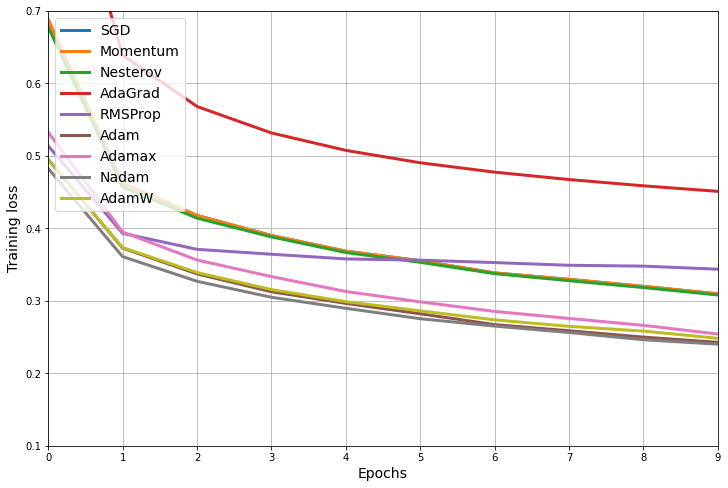

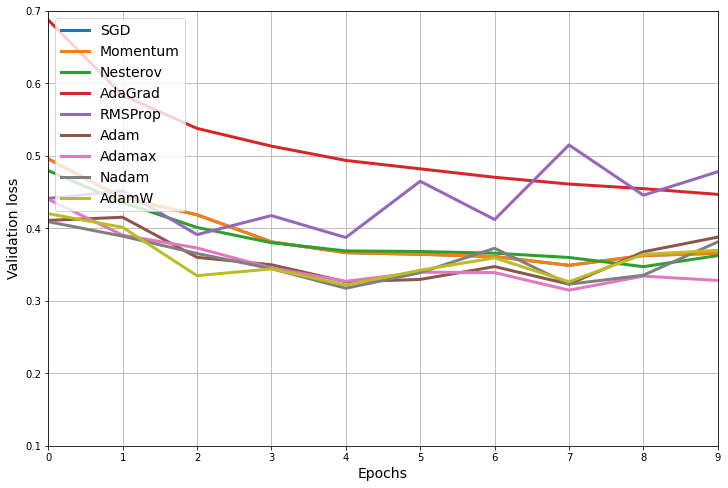

In [46]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

for loss in ('loss', 'val_loss'):
    plt.figure(figsize=(12, 8))
    opt_names = 'SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW'
    for history, opt_name in zip(
        [
            history_sgd,
            history_momentum,
            history_nesterov,
            history_adagrad,
            history_rmsprop,
            history_adam,
            history_adamax,
            history_nadam,
            history_adamw,
        ],
        opt_names.split(),
    ):
        plt.plot(history.history[loss], label=f'{opt_name}', linewidth=3)

    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel({'loss': 'Training loss', 'val_loss': 'Validation loss'}[loss])
    plt.legend(loc='upper left')
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling
Finding a good learning rate is very important:
- If we set it much too high, training may diverge. 
- If we set it too low, training will eventually converge to the optimum, but it will take a very long time. 
- If we set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum and never really settling down. 

If we have a limited computing budget, we may have to interrupt training before it has converged properly, yielding a suboptimal solution.

<center>
  <img 
    src="../images/11/learning_curves.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

As discussed in Chapter 10, we can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. We can then reinitialize our model and train it with that learning rate.

But we can do better than a constant learning rate. These strategies are called 
*learning schedules*:

### Power Scheduling
Set the learning rate to a function of the iteration number $t: \eta(t)=\eta_0/(1+t/s)^c$. The initial learning rate $\eta_0$, the power $c$ (typically set to 1), and the steps $s$ are hyperparameters. The learning rate drops at each step. After $s$ steps, the learning rate is down to $\eta_0/2$. After $s$ more steps it is down to $\eta_0/3$, then it goes down to $\eta_0/4$, then $\eta_0/5$, and so on. This schedule first drops quickly, then more and more slowly. Power scheduling requires tuning $\eta_0$ and $s$ (and possibly $c$).

Keras sets $c$ to 1. There was a `decay` argument in Keras optimizers defined as inverse of $s$, but now it is deprecated. Those old optimizers are still available in `keras.optimizers.legacy`:

In [47]:
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

But we should use the schedulers in `keras.optimizers.schedules` instead:

In [48]:
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False,
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

The `InverseTimeDecay` scheduler uses `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)`. If we set `staircase=True`, then it replaces `step / decay_step` with `floor(step / decay_step)`.

In [49]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7004 - accuracy: 0.7588 - val_loss: 0.4991 - val_accuracy: 0.8206
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4781 - accuracy: 0.8316 - val_loss: 0.4477 - val_accuracy: 0.8372
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4293 - accuracy: 0.8487 - val_loss: 0.4177 - val_accuracy: 0.8498
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4053 - accuracy: 0.8563 - val_loss: 0.3987 - val_accuracy: 0.8602
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3864 - accuracy: 0.8633 - val_loss: 0.3859 - val_accuracy: 0.8612
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3720 - accuracy: 0.8675 - val_loss: 0.3942 - val_accuracy: 0.8584
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3616 - accuracy: 0.8709 - val_loss: 0.3706 - val_accuracy:

Let’s plot it:

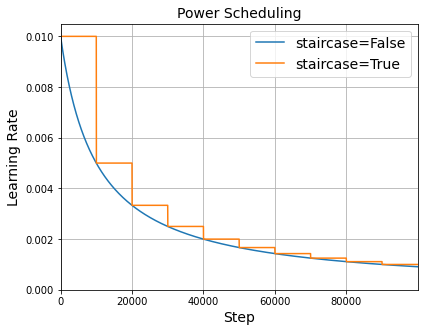

In [50]:
initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs, '-', label='staircase=False')
plt.plot(steps, lrs2, '-', label='staircase=True')
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Power Scheduling', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Exponential Scheduling
Set the learning rate to $\eta(t)=\eta_00.1^{t/s}$. The learning rate will gradually drop by a factor of 10 every $s$ steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every $s$ steps.

In [51]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False,
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

The `ExponentialDecay` scheduler uses `learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)`. If we set `staircase=True`, then it replaces `step / decay_step` with `floor(step / decay_step)`.

In [52]:
history_exponential_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6916 - accuracy: 0.7632 - val_loss: 0.5030 - val_accuracy: 0.8254
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4832 - accuracy: 0.8311 - val_loss: 0.4601 - val_accuracy: 0.8358
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4372 - accuracy: 0.8449 - val_loss: 0.4256 - val_accuracy: 0.8524
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4131 - accuracy: 0.8546 - val_loss: 0.4037 - val_accuracy: 0.8568
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3952 - accuracy: 0.8596 - val_loss: 0.3950 - val_accuracy: 0.8598
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3825 - accuracy: 0.8640 - val_loss: 0.4010 - val_accuracy: 0.8584
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3739 - accuracy: 0.8667 - val_loss: 0.3851 - val_accuracy:

Let’s plot it:

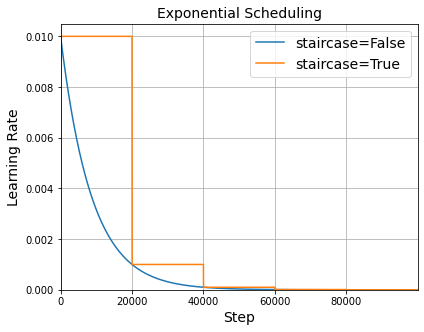

In [53]:
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.figure(dpi=72)
plt.plot(steps, lrs, '-', label='staircase=False')
plt.plot(steps, lrs2, '-', label='staircase=True')
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Exponential Scheduling', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras also provides a `LearningRateScheduler` callback class that lets us define our own scheduling function. Let’s see how we could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step:

In [54]:
from typing import Callable


def exponential_decay(lr0: float, s: int) -> Callable[[int], float]:
    def exponential_decay_fn(epoch: int) -> float:
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Let’s build and compile a model for Fashion MNIST:

In [55]:
keras.utils.set_random_seed(42)
model = build_model()
optimizer = keras.optimizers.SGD(learning_rate=0.001)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [56]:
n_epochs = 20

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6905 - accuracy: 0.7643 - val_loss: 0.4814 - val_accuracy: 0.8330 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4672 - accuracy: 0.8357 - val_loss: 0.4488 - val_accuracy: 0.8374 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4212 - accuracy: 0.8503 - val_loss: 0.4118 - val_accuracy: 0.8532 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3975 - accuracy: 0.8593 - val_loss: 0.3884 - val_accuracy: 0.8636 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3781 - accuracy: 0.8657 - val_loss: 0.3772 - val_accuracy: 0.8642 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3634 - accuracy: 0.8710 - val_loss: 0.3779 - val_accuracy: 0.8662 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 3s

**Tip**: After training, `history.history['lr']` gives us access to the list of learning rates used during training.

When we save a model, the epoch does not get saved, and it gets reset to 0 every time we call the `fit()` method. If our schedule function uses the `epoch` argument, and we were to continue training a model where it left off, this could lead to a very large learning rate, which would likely damage our model’s weights. One solution is to manually set the `fit()` method’s `initial_epoch` argument so the epoch starts at the right value.

Another option is to take the current learning rate as a second argument:

In [57]:
def exponential_decay_fn(epoch: int, lr: float) -> float:
    return lr * 0.1 ** (1 / 20)

**Extra material**: If we want to update the learning rate at each iteration rather than at each epoch, we can write our own callback class:

In [58]:
from typing import Optional


class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, n_steps: int = 40_000) -> None:
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(
        self, batch: int, logs: Optional[dict[str, float]] = None
    ) -> None:
        # Note that the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(
        self, epoch: int, logs: Optional[dict[str, float]] = None
    ) -> None:
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [59]:
lr0 = 0.01
model = build_model()
optimizer = keras.optimizers.SGD(learning_rate=lr0)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [60]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[exp_decay],
)

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6947 - accuracy: 0.7635 - val_loss: 0.5014 - val_accuracy: 0.8224 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4718 - accuracy: 0.8349 - val_loss: 0.4530 - val_accuracy: 0.8382 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4255 - accuracy: 0.8500 - val_loss: 0.4216 - val_accuracy: 0.8526 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4025 - accuracy: 0.8587 - val_loss: 0.3954 - val_accuracy: 0.8618 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3840 - accuracy: 0.8643 - val_loss: 0.3847 - val_accuracy: 0.8612 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3696 - accuracy: 0.8689 - val_loss: 0.3908 - val_accuracy: 0.8558 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================] - 4s

### Piecewise Constant Scheduling
Use a constant learning rate for a number of epochs (e.g., $\eta_0=0.1$ for 5 epochs), then a smaller learning rate for another number of epochs (e.g., $\eta_0=0.001$ for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

In [61]:
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000], values=[0.01, 0.005, 0.001]
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

In [62]:
history_piecewise_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6942 - accuracy: 0.7617 - val_loss: 0.4892 - val_accuracy: 0.8318
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4751 - accuracy: 0.8340 - val_loss: 0.4603 - val_accuracy: 0.8346
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4280 - accuracy: 0.8500 - val_loss: 0.4245 - val_accuracy: 0.8542
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4035 - accuracy: 0.8581 - val_loss: 0.3867 - val_accuracy: 0.8626
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3828 - accuracy: 0.8650 - val_loss: 0.3827 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3665 - accuracy: 0.8700 - val_loss: 0.3880 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3539 - accuracy: 0.8730 - val_loss: 0.3669 - val_accuracy:

Let’s plot it:

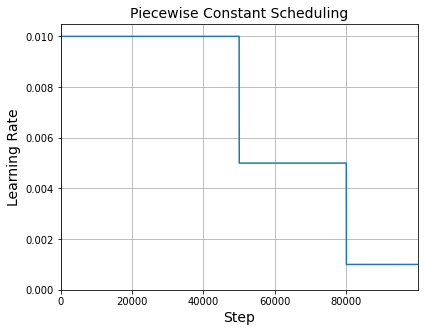

In [63]:
boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, '-')
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Piecewise Constant Scheduling', fontsize=14)
plt.grid(True)
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually:

In [64]:
def piecewise_constant(
    boundaries: list[int], values: list[float]
) -> Callable[[int], list[float]]:
    boundaries = np.array([0] + boundaries)
    values = np.array(values)

    def piecewise_constant_fn(epoch: int) -> list[float]:
        return values[(boundaries > epoch).argmax() - 1]

    return piecewise_constant_fn


piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [65]:
n_epochs = 25

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/25
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5433 - accuracy: 0.8087 - val_loss: 0.4586 - val_accuracy: 0.8288 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4487 - accuracy: 0.8439 - val_loss: 0.4608 - val_accuracy: 0.8350 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4263 - accuracy: 0.8502 - val_loss: 0.4234 - val_accuracy: 0.8568 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4241 - accuracy: 0.8537 - val_loss: 0.4359 - val_accuracy: 0.8490 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4080 - accuracy: 0.8584 - val_loss: 0.4165 - val_accuracy: 0.8560 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3544 - accuracy: 0.8738 - val_loss: 0.3830 - val_accuracy: 0.8662 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 3s

We’ve looked at `InverseTimeDecay`, `ExponentialDecay`, and `PiecewiseConstantDecay`. A few more schedulers are available in `keras.optimizers.schedules`, here is the full list:

In [66]:
for name in sorted(dir(keras.optimizers.schedules)):
    # Must start with capital letter
    if name[0] == name[0].lower():
        continue
    scheduler_class = getattr(keras.optimizers.schedules, name)
    print(f'• {name} - {scheduler_class.__doc__.splitlines()[0]}')

• CosineDecay - A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts - A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay - A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay - A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule - The learning rate schedule base class.
• PiecewiseConstantDecay - A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay - A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling
Measure the validation error every $N$ steps (just like for early stopping), and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

Let’s build and compile a model:

In [67]:
model = build_model()
optimizer = keras.optimizers.SGD(learning_rate=lr0)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [68]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6807 - accuracy: 0.7679 - val_loss: 0.4814 - val_accuracy: 0.8310 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4659 - accuracy: 0.8343 - val_loss: 0.4615 - val_accuracy: 0.8306 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4201 - accuracy: 0.8505 - val_loss: 0.4199 - val_accuracy: 0.8490 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3957 - accuracy: 0.8590 - val_loss: 0.3845 - val_accuracy: 0.8614 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3754 - accuracy: 0.8658 - val_loss: 0.3742 - val_accuracy: 0.8614 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3588 - accuracy: 0.8709 - val_loss: 0.3853 - val_accuracy: 0.8628 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 3s

Let’s plot it:

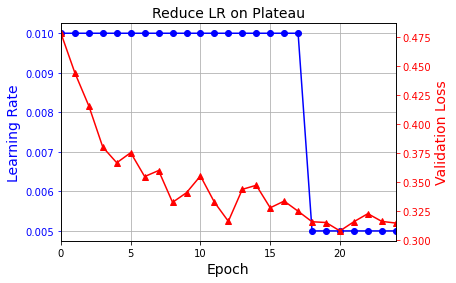

In [69]:
plt.plot(history.epoch, history.history['lr'], 'bo-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate', color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history['val_loss'], 'r^-')
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title('Reduce LR on Plateau', fontsize=14)
plt.show()

### 1Cycle Scheduling
1cycle was introduced in a 2018 paper [“A Disciplined Approach to Neural Network Hyper-Parameters: Part 1—Learning Rate, Batch Size, Momentum, and Weight Decay”](https://homl.info/1cycle) by Leslie Smith. It starts by increasing the initial learning rate $\eta_0$, growing linearly up to $\eta_1$ halfway through training. Then it decreases the learning rate linearly down to $\eta_0$ again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). $\eta_1$ is chosen using the same approach we used to find the optimal learning rate, and $\eta_0$ is usually 10 times lower.

When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. This feat was dubbed *super-convergence*.

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs['loss']` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch’s loss.

In [70]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor: float) -> None:
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(
        self, epoch: int, logs: Optional[dict[str, float]] = None
    ) -> None:
        self.sum_of_epoch_losses = 0

    def on_batch_end(
        self, batch: int, logs: Optional[dict[str, float]] = None
    ) -> None:
        # The epoch’s mean loss so far
        mean_epoch_loss = logs['loss']
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(
            self.model.optimizer.learning_rate,
            self.model.optimizer.learning_rate * self.factor,
        )

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and  corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [71]:
def find_learning_rate(
    model: keras.Model,
    X: np.ndarray,
    y: np.ndarray,
    epochs: int = 1,
    batch_size: int = 32,
    min_rate: float = 1e-4,
    max_rate: float = 1,
) -> tuple[list[float], ...]:
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [72]:
def plot_lr_vs_loss(rates: list[float], losses: list[float]) -> None:
    plt.plot(rates, losses, 'b')
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color='k')
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.grid()

Let’s build a simple Fashion MNIST model and compile it:

In [73]:
model = build_model()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy'],
)

Now let’s find the optimal max learning rate for 1cycle:

430/430 [==============================] - 1s 1ms/step - loss: 1.7725 - accuracy: 0.4122


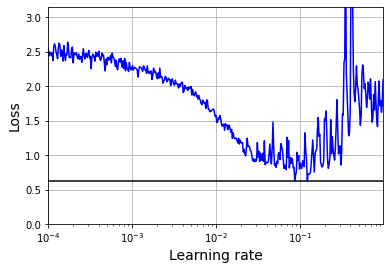

In [74]:
batch_size = 128
rates, losses = find_learning_rate(
    model, X_train, y_train, epochs=1, batch_size=batch_size
)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around $10^{-1}$.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described earlier.

In [75]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(
        self,
        iterations: int,
        max_lr: float = 1e-3,
        start_lr: Optional[float] = None,
        last_iterations: Optional[int] = None,
        last_lr: Optional[float] = None,
    ) -> None:
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(
        self, iter1: int, iter2: int, lr1: float, lr2: float
    ) -> float:
        return (self.iteration - iter1) * (lr2 - lr1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch: int, logs: dict[str, float]) -> None:
        if self.iteration < self.half_iteration:
            lr = self._interpolate(
                0, self.half_iteration, self.start_lr, self.max_lr
            )
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(
                self.half_iteration,
                2 * self.half_iteration,
                self.max_lr,
                self.start_lr,
            )
        else:
            lr = self._interpolate(
                2 * self.half_iteration,
                self.iterations,
                self.start_lr,
                self.last_lr,
            )
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let’s build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [76]:
model = build_model()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(),
    metrics=['accuracy'],
)
n_epochs = 25
onecycle = OneCycleScheduler(
    math.ceil(len(X_train) / batch_size) * n_epochs, max_lr=0.1
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[onecycle],
)

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.9502 - accuracy: 0.6913 - val_loss: 0.6003 - val_accuracy: 0.7874
Epoch 2/25
430/430 [==============================] - 1s 1ms/step - loss: 0.5695 - accuracy: 0.8025 - val_loss: 0.4918 - val_accuracy: 0.8248
Epoch 3/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4954 - accuracy: 0.8252 - val_loss: 0.4762 - val_accuracy: 0.8264
Epoch 4/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4515 - accuracy: 0.8402 - val_loss: 0.4261 - val_accuracy: 0.8478
Epoch 5/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4225 - accuracy: 0.8492 - val_loss: 0.4066 - val_accuracy: 0.8486
Epoch 6/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3958 - accuracy: 0.8571 - val_loss: 0.4787 - val_accuracy: 0.8224
Epoch 7/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3787 - accuracy: 0.8626 - val_loss: 0.3917 - val_accuracy: 0.8566
Epoch 

A 2013 paper [“An Empirical Study of Learning Rates in Deep Neural Networks for Speech Recognition”](https://homl.info/63) by Andrew Senior et al. compared the performance of some of the most popular learning schedules when using momentum optimization to train deep neural networks for speech recognition. In that setting, both performance scheduling and exponential scheduling performed well. 1cycle approach seems to perform even better.

## Avoiding Overfitting Through Regularization
    With four parameters I can fit an elephant and with five I can make him wiggle his trunk.
    —John von Neumann
    
With thousands of parameters, we can fit the whole zoo. We already know about early stopping and batch normalization. Let’s examine other popular regularization techniques:

### $\ell_1$ and $\ell_2$ Regularization

In [77]:
layer = keras.layers.Dense(
    100,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=keras.regularizers.l2(0.01),
)

The `l2()` function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. 

Or use `l1(0.1)` for $\ell_1$ regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both $\ell_1$ and $\ell_2$ regularization, with factors 0.1 and 0.01 respectively.

In [78]:
# For reproducibility
keras.utils.set_random_seed(42)

In [79]:
from functools import partial

RegularizedDense = partial(
    keras.layers.Dense,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=keras.regularizers.l2(0.01),
)

model = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        RegularizedDense(100),
        RegularizedDense(100),
        RegularizedDense(10, activation='softmax'),
    ]
)

Let’s Compile and train the model:

In [80]:
optimizer = keras.optimizers.SGD(learning_rate=0.02)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = model.fit(
    X_train, y_train, epochs=2, validation_data=(X_valid, y_valid)
)

Epoch 1/2
1719/1719 [==============================] - 2s 878us/step - loss: 3.1224 - accuracy: 0.7748 - val_loss: 1.8602 - val_accuracy: 0.8264
Epoch 2/2
1719/1719 [==============================] - 1s 814us/step - loss: 1.4263 - accuracy: 0.8159 - val_loss: 1.1269 - val_accuracy: 0.8182


### Dropout
It was proposed in a paper [“Improving Neural Networks by Preventing Co-Adaptation of Feature Detectors”](https://homl.info/64) by Geoffrey Hinton et al. in 2012 and further detailed in a 2014 paper [“Dropout: A Simple Way to Prevent Neural Networks from Overfitting”,](https://homl.info/65) by Nitish Srivastava et al. 

At every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out”, meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter $p$ is called the *dropout rate*, and it is typically set between 10% and 50%: closer to 20%–30% in recurrent neural nets, and closer to 40%–50% in convolutional neural networks. After training, neurons don’t get dropped anymore.

Suppose $p$ is 75%: on average only 25% of all neurons are active at each step during training. This means that after training, a neuron would be connected to four times as many input neurons as it would be during training. To compensate for this fact, we need to multiply each neuron’s input connection weights by four during training. If we don’t, the neural network will not perform well as it will see different data during and after training. More generally, we need to divide the connection weights by the *keep probability* ($1-p$) during training.

Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, we get a more robust network that generalizes better.

**Tip**: In practice, we can usually apply dropout only to the neurons in the top one to three layers (excluding the output layer).

In [81]:
# For reproducibility
keras.utils.set_random_seed(42)

In [82]:
model = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(
            100, activation='relu', kernel_initializer='he_normal'
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(10, activation='softmax'),
    ]
)

Let’s compile and train the model:

In [83]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = model.fit(
    X_train, y_train, epochs=10, validation_data=(X_valid, y_valid)
)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6703 - accuracy: 0.7536 - val_loss: 0.4498 - val_accuracy: 0.8342
Epoch 2/10
1719/1719 [==============================] - 2s 996us/step - loss: 0.5103 - accuracy: 0.8136 - val_loss: 0.4401 - val_accuracy: 0.8296
Epoch 3/10
1719/1719 [==============================] - 2s 998us/step - loss: 0.4712 - accuracy: 0.8263 - val_loss: 0.3806 - val_accuracy: 0.8554
Epoch 4/10
1719/1719 [==============================] - 2s 977us/step - loss: 0.4488 - accuracy: 0.8337 - val_loss: 0.3711 - val_accuracy: 0.8608
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4342 - accuracy: 0.8409 - val_loss: 0.3672 - val_accuracy: 0.8606
Epoch 6/10
1719/1719 [==============================] - 2s 983us/step - loss: 0.4245 - accuracy: 0.8427 - val_loss: 0.3706 - val_accuracy: 0.8600
Epoch 7/10
1719/1719 [==============================] - 2s 995us/step - loss: 0.4131 - accuracy: 0.8467 - val_loss: 0.3582 - val

**Warning**: The training accuracy looks like it’s lower than the validation accuracy, but that’s just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the “real” training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [84]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 1s 578us/step - loss: 0.3082 - accuracy: 0.8849


[0.30816400051116943, 0.8849090933799744]

In [85]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 588us/step - loss: 0.3629 - accuracy: 0.8700


[0.3628920316696167, 0.8700000047683716]

**Tip**: If we want to regularize a self-normalizing network based on the SELU activation function, we should use *alpha dropout*: this is a variant of dropout that preserves the mean and standard deviation of its inputs. It was introduced in the same paper as SELU, as regular dropout would break self-normalization. Keras includes `AlphaDropout`.

### Monte Carlo (MC) Dropout
In 2016, a paper [“Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning”](https://homl.info/mcdropout) by Yarin Gal and 
Zoubin Ghahramani added a few more good reasons to use dropout:
- First, they established a profound connection between dropout networks and approximate Bayesian inference (Specifically, they show that training a dropout network is mathematically equivalent to approximate Bayesian inference in a specific type of probabilistic model called a *deep Gaussian process*), giving dropout a solid mathematical justification.
- Second, the authors introduced a powerful technique called *MC dropout*, which can boost the performance of any trained dropout model without having to retrain it or even modify it at all. It also provides a much better measure of the model’s uncertainty, and it can be implemented in just a few lines of code.

In [86]:
# For reproducibility
keras.utils.set_random_seed(42)

**Note**: `model(X)` is similar to `model.predict(X)` except it returns a tensor rather than a NumPy array, and it supports the `training` argument.

In [87]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

`training=True` ensures that the `Dropout` layer remains active, so all predictions will be a bit different. We just make 100 predictions over the test set, and we compute their average. Averaging over multiple predictions with dropout turned on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout turned off.

In [88]:
model.predict(X_test[:1]).round(3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.024, 0.   , 0.132, 0.   ,
        0.844]], dtype=float32)

The model is fairly confident (84.4%) that this image belongs to class 9 (ankle boot). Compare this with the MC dropout prediction:

In [89]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.067, 0.   , 0.209, 0.001,
       0.723], dtype=float32)

The model still seems to prefer class 9, but its confidence dropped down to 72.3%, and the estimated probabilities for classes 5 (sandal) and 7 (sneaker) have increased, which makes sense given they’re also footwear.

In [90]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.001, 0.   , 0.096, 0.   , 0.162, 0.001,
       0.183], dtype=float32)

If we were building a risk-sensitive system (e.g., a medical or financial 
system), we would probably treat such an uncertain prediction with extreme 
caution. We would definitely not treat it like an 84.4% confident prediction.

In [91]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8717

**Note**: The number of Monte Carlo samples we use (100 in this example) is a hyperparameter we can tweak.

If our model contains other layers that behave in a special way during training (such as `BatchNormalization` layers), then we should not force training mode like we just did. Instead:

In [92]:
class MCDropout(keras.layers.Dropout):
    def call(
        self, inputs: tf.Tensor, training: Optional[bool] = None
    ) -> tf.Tensor:
        return super().call(inputs, training=True)

Here is how to convert `Dropout` to `MCDropout` in a `Sequential` model:

In [93]:
Dropout = keras.layers.Dropout
mc_model = keras.Sequential(
    [
        MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
        for layer in model.layers
    ]
)
mc_model.set_weights(model.get_weights())

In [94]:
mc_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 784)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 100)               78500     
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               10100     
_________________________________________________________________
mc_dropout_2 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 10)              

Now we can use the model with MC Dropout:

In [95]:
keras.utils.set_random_seed(42)
np.mean([mc_model.predict(X_test[:1]) for sample in range(100)], axis=0).round(
    2
)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.17, 0.  , 0.76]],
      dtype=float32)

### Max-Norm Regularization
For each neuron, it constrains the weights $\mathbf{w}$ of the incoming connections such that $\|\mathbf{w}\|_2\leq r$, where $R$ is the max-norm hyperparameter. Max-norm does not add a regularization loss term to the overall loss function. Instead, it is typically implemented by computing $\|\mathbf{w}\|_2$ after each training step and rescaling $\mathbf{w}$ if needed ($\mathbf{w}\gets\mathbf{w}r/\|\mathbf{w}\|_2$).

Max-norm regularization can also help alleviate the unstable gradients problems (if we are not using batch normalization).

In [96]:
dense = keras.layers.Dense(
    100,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_constraint=keras.constraints.max_norm(1.0),
)

Here is how to apply max norm to every hidden layer in a model:

In [97]:
MaxNormDense = partial(
    keras.layers.Dense,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_constraint=keras.constraints.max_norm(1.0),
)

keras.utils.set_random_seed(42)
model = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        MaxNormDense(100),
        MaxNormDense(100),
        keras.layers.Dense(10, activation='softmax'),
    ]
)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = model.fit(
    X_train, y_train, epochs=10, validation_data=(X_valid, y_valid)
)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5500 - accuracy: 0.8015 - val_loss: 0.4510 - val_accuracy: 0.8242
Epoch 2/10
1719/1719 [==============================] - 2s 960us/step - loss: 0.4089 - accuracy: 0.8499 - val_loss: 0.3956 - val_accuracy: 0.8504
Epoch 3/10
1719/1719 [==============================] - 2s 974us/step - loss: 0.3777 - accuracy: 0.8604 - val_loss: 0.3693 - val_accuracy: 0.8680
Epoch 4/10
1719/1719 [==============================] - 2s 943us/step - loss: 0.3581 - accuracy: 0.8690 - val_loss: 0.3517 - val_accuracy: 0.8716
Epoch 5/10
1719/1719 [==============================] - 2s 949us/step - loss: 0.3416 - accuracy: 0.8729 - val_loss: 0.3433 - val_accuracy: 0.8682
Epoch 6/10
1719/1719 [==============================] - 2s 951us/step - loss: 0.3368 - accuracy: 0.8756 - val_loss: 0.4045 - val_accuracy: 0.8582
Epoch 7/10
1719/1719 [==============================] - 2s 935us/step - loss: 0.3293 - accuracy: 0.8767 - val_loss: 0.4168 - v

After each training iteration, the model’s `fit()` method will call the object returned by `max_norm()`, passing it the layer’s weights and getting rescaled weights in return, which then replace the layer’s weights.

The `max_norm()` function has an axis argument that defaults to 0. A Dense layer usually has weights of shape [*number of inputs*, *number of neurons*], so using `axis=0` means that the max-norm constraint will apply independently to each neuron’s weight vector. If we want to use max-norm with convolutional layers, make sure to set the `max_norm()` constraint’s axis argument appropriately (usually `axis=[0, 1, 2]`).

## Summary and Practical Guidelines
In this chapter we have covered a wide range of techniques, and we may be wondering which ones we should use. This depends on the task, and there is no clear consensus yet, but I have found the configuration in table below to work fine in most cases, without requiring much hyperparameter tuning. That said, please do not consider these defaults as hard rules!

| Hyperparameter         | Default value                           |
|------------------------|-----------------------------------------|
| Kernel initializer     | He initialization                       |
| Activation function    | ReLU if shallow; Swish if deep          |
| Normalization          | None if shallow; batch norm if deep     |
| Regularization         | Early stopping; weight decay if needed  |
| Optimizer              | Nesterov accelerated gradients or AdamW |
| Learning rate schedule | Performance scheduling or 1cycle        |

If the network is a simple stack of dense layers, then it can self-normalize, and we should use the configuration in following table instead:

| Hyperparameter         | Default value                    |
|------------------------|----------------------------------|
| Kernel initializer     | LeCun initialization             |
| Activation function    | SELU                             |
| Normalization          | None (self-normalization)        |
| Regularization         | Alpha dropout if needed          |
| Optimizer              | Nesterov accelerated gradients   |
| Learning rate schedule | Performance scheduling or 1cycle |

Don’t forget to normalize the input features! We should also try to reuse parts of a pretrained neural network if we can find one that solves a similar problem, or use unsupervised pretraining if we have a lot of unlabeled data, or use pretraining on an auxiliary task if we have a lot of labeled data for a similar task.

While the previous guidelines should cover most cases, here are some exceptions:
- If we need a sparse model, we can use $\ell_1$ regularization (and optionally zero out the tiny weights after training). If we need an even sparser model, we can use the TensorFlow Model Optimization Toolkit. This will break self-normalization, so we should use the default configuration in this case.
- If we need a low-latency model (one that performs lightning-fast 
predictions), we may need to use fewer layers, use a fast activation function such as ReLU or leaky ReLU, and fold the batch normalization layers into the previous layers after training. Having a sparse model will also help. Finally, we may want to reduce the float precision from 32 bits to 16 or even 8 bits. Again, check out TF-MOT.
- If we are building a risk-sensitive application, or inference latency is not very important in our application, we can use MC dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates. 

## Exercises
1. What is the problem that Glorot initialization and He initialization aim to fix?
> Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?
> No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It’s like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. Is it OK to initialize the bias terms to 0?
> It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that’s OK too; it does not make much difference.
4. In which cases would we want to use each of the activation functions we discussed in this chapter?
> ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases. Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model’s quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give us a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if we need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when we need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions e.g., for the coding layer of variational autoencoders). The softplus activation function is useful in the output layer when we need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. What may happen if we set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer?
> The algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. Name three ways we can produce a sparse model.
> One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, we can apply $\ell_1$ regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
7. Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC dropout?
> Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout we generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.
8. Practice training a deep neural network on the CIFAR10 image dataset:
- **a.** Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the Swish activation function.

In [98]:
keras.utils.set_random_seed(42)

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(
        keras.layers.Dense(
            100, activation='swish', kernel_initializer='he_normal'
        )
    )

- **b.** Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. We can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 $\times$ 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so we’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time we change the model’s architecture or hyperparameters.
> Let’s add the output layer to the model:

In [99]:
model.add(keras.layers.Dense(10, activation='softmax'))

> Let’s use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [100]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

> Let’s load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let’s use the first 5,000 images of the original training set as the validation set:

In [101]:
cifar10 = keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

> Now we can create the callbacks we need and train the model:

In [102]:
from pathlib import Path

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'my_cifar10_model', save_best_only=True
)
# Increment every time we train the model
run_index = 1
run_logdir = Path() / 'my_cifar10_logs' / f'run_{run_index:03d}'
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [103]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [104]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks,
)

Epoch 1/100
1407/1407 [==============================] - 17s 10ms/step - loss: 4.0462 - accuracy: 0.1597 - val_loss: 2.1441 - val_accuracy: 0.2036
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 2.0667 - accuracy: 0.2320 - val_loss: 2.0134 - val_accuracy: 0.2472
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.9472 - accuracy: 0.2819 - val_loss: 1.9427 - val_accuracy: 0.2796
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8637 - accuracy: 0.3182 - val_loss: 1.8934 - val_accuracy: 0.3222
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7974 - accuracy: 0.3465 - val_loss: 1.8389 - val_accuracy: 0.3284
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.7446 - accuracy: 0.3664 - val_loss: 2.0006 - val_accuracy: 0.3030
Epoch 7/100
1407/1407 [==============================] - 12s 8ms/step - loss: 1.6974 - accuracy: 0.3852 - val_loss: 1.707

In [105]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5062 - accuracy: 0.4676


[1.5061508417129517, 0.4675999879837036]

> The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let’s see if we can improve the model using Batch Normalization.
- **c.** Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?
> The code below is very similar to the code above, with a few changes:
> - I added a BN layer after every Dense layer (before the activation function), except for the output layer.
> - I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
> - I renamed the run directories to run_bn_* and the model file name to `my_cifar10_bn_model`.

In [106]:
keras.utils.set_random_seed(42)

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('swish'))

model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'my_cifar10_bn_model', save_best_only=True
)
# Increment every time we train the model
run_index = 1
run_logdir = Path() / 'my_cifar10_logs' / f'run_bn_{run_index:03d}'
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks,
)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 32s 18ms/step - loss: 2.0374 - accuracy: 0.2525 - val_loss: 1.8766 - val_accuracy: 0.3154
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7874 - accuracy: 0.3542 - val_loss: 1.8784 - val_accuracy: 0.3268
Epoch 3/100
1407/1407 [==============================] - 20s 15ms/step - loss: 1.6806 - accuracy: 0.3969 - val_loss: 1.9764 - val_accuracy: 0.3252
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6112 - accuracy: 0.4228 - val_loss: 1.7087 - val_accuracy: 0.3750
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5521 - accuracy: 0.4476 - val_loss: 1.6272 - val_accuracy: 0.4176
Epoch 6/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5030 - accuracy: 0.4660 - val_loss: 1.5401 - val_accuracy: 0.4452
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.4559 - accuracy: 0.4812 - val_loss: 1

[1.4236289262771606, 0.5073999762535095]

> - *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
> - *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It’s still not a very good model, but at least it’s much better than before (a convolutional neural network would do much better, but that’s a different topic).
> - *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.
- **d.** Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [107]:
keras.utils.set_random_seed(42)

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(
        keras.layers.Dense(
            100, kernel_initializer='lecun_normal', activation='selu'
        )
    )

model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'my_cifar10_selu_model', save_best_only=True
)
# Increment every time we train the model
run_index = 1
run_logdir = Path() / 'my_cifar10_logs' / f'run_selu_{run_index:03d}'
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=callbacks,
)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 1.9385 - accuracy: 0.3046 - val_loss: 1.8175 - val_accuracy: 0.3510
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7241 - accuracy: 0.3869 - val_loss: 1.7677 - val_accuracy: 0.3614
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6272 - accuracy: 0.4263 - val_loss: 1.6878 - val_accuracy: 0.4054
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5643 - accuracy: 0.4492 - val_loss: 1.6589 - val_accuracy: 0.4304
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5080 - accuracy: 0.4712 - val_loss: 1.5651 - val_accuracy: 0.4538
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4613 - accuracy: 0.4872 - val_loss: 1.5305 - val_accuracy: 0.4678
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4174 - accuracy: 0.5077 - val_loss: 1

[1.4607702493667603, 0.5026000142097473]

> This model reached the first model’s validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it’s the fastest model to train so far.
- **e.** Try regularizing the model with alpha dropout. Then, without retraining our model, see if we can achieve better accuracy using MC Dropout.

In [108]:
keras.utils.set_random_seed(42)

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(
        keras.layers.Dense(
            100, kernel_initializer='lecun_normal', activation='selu'
        )
    )

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'my_cifar10_alpha_dropout_model', save_best_only=True
)
# Increment every time we train the model
run_index = 1
run_logdir = Path() / 'my_cifar10_logs' / f'run_alpha_dropout_{run_index:03d}'
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=callbacks,
)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 18s 11ms/step - loss: 1.8950 - accuracy: 0.3239 - val_loss: 1.7556 - val_accuracy: 0.3812
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6618 - accuracy: 0.4130 - val_loss: 1.6563 - val_accuracy: 0.4114
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5770 - accuracy: 0.4432 - val_loss: 1.6507 - val_accuracy: 0.4232
Epoch 4/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.5081 - accuracy: 0.4672 - val_loss: 1.5892 - val_accuracy: 0.4566
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4561 - accuracy: 0.4902 - val_loss: 1.5382 - val_accuracy: 0.4696
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4094 - accuracy: 0.5050 - val_loss: 1.5236 - val_accuracy: 0.4818
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3636 - accuracy: 0.5232 - val_loss: 1

[1.4779616594314575, 0.498199999332428]

> The model reaches 48.1% accuracy on the validation set. That’s worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.
>
> Let’s use MC Dropout now:

In [109]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        return super().call(inputs, training=True)

> Now let’s create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [110]:
mc_model = keras.Sequential(
    [
        (
            MCAlphaDropout(layer.rate)
            if isinstance(layer, keras.layers.AlphaDropout)
            else layer
        )
        for layer in model.layers
    ]
)

> Then let’s add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [111]:
def mc_dropout_predict_probas(
    mc_model: keras.Model, X: np.ndarray, n_samples: int = 10
) -> np.ndarray:
    Y_probas = [mc_model.predict(X) for _ in range(n_samples)]
    return np.mean(Y_probas, axis=0)


def mc_dropout_predict_classes(
    mc_model: keras.Model, X: np.ndarray, n_samples: int = 10
) -> np.ndarray:
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

> Now let’s make predictions for all the instances in the validation set, and compute the accuracy:

In [112]:
keras.utils.set_random_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

0.4984

>  We get back to roughly the accuracy of the model without dropout in this 
> case (about 50.3% accuracy).
>
> So the best model we got in this exercise is the Batch Normalization model.
- **f.** Retrain our model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [113]:
keras.utils.set_random_seed(42)

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(
        keras.layers.Dense(
            100, kernel_initializer='lecun_normal', activation='selu'
        )
    )

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.SGD()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

352/352 [==============================] - 3s 8ms/step - loss: nan - accuracy: 0.1706


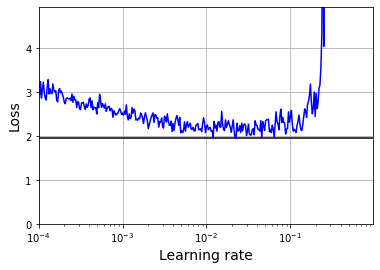

In [114]:
batch_size = 128
rates, losses = find_learning_rate(
    model, X_train_scaled, y_train, epochs=1, batch_size=batch_size
)
plot_lr_vs_loss(rates, losses)

In [115]:
keras.utils.set_random_seed(42)

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(
        keras.layers.Dense(
            100, kernel_initializer='lecun_normal', activation='selu'
        )
    )

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.SGD(learning_rate=2e-2)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [116]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[onecycle],
)

Epoch 1/15
352/352 [==============================] - 3s 9ms/step - loss: 2.0559 - accuracy: 0.2839 - val_loss: 1.7917 - val_accuracy: 0.3768
Epoch 2/15
352/352 [==============================] - 3s 8ms/step - loss: 1.7596 - accuracy: 0.3797 - val_loss: 1.6566 - val_accuracy: 0.4258
Epoch 3/15
352/352 [==============================] - 3s 8ms/step - loss: 1.6199 - accuracy: 0.4247 - val_loss: 1.6395 - val_accuracy: 0.4260
Epoch 4/15
352/352 [==============================] - 3s 9ms/step - loss: 1.5451 - accuracy: 0.4524 - val_loss: 1.6202 - val_accuracy: 0.4408
Epoch 5/15
352/352 [==============================] - 3s 8ms/step - loss: 1.4952 - accuracy: 0.4691 - val_loss: 1.5981 - val_accuracy: 0.4488
Epoch 6/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4541 - accuracy: 0.4842 - val_loss: 1.5720 - val_accuracy: 0.4490
Epoch 7/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4171 - accuracy: 0.4967 - val_loss: 1.6035 - val_accuracy: 0.4470
Epoch 

> One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model’s performance (from 50.7% to 52.0%).